# Imports

In [1]:
import sys 
import os
sys.path.append("../")
from classifier.DenseNet import pretrained_classifier
from explainer.networks_128 import Discriminator_Ordinal, Generator_Encoder_Decoder, Discriminator_Contrastive
import tensorflow.contrib.slim as slim
import tensorflow as tf
import numpy as np
from utils import *
from losses import *
import pdb
import yaml
import time
import pandas as pd
import scipy.io as sio
from datetime import datetime
import random
import warnings
import argparse
warnings.filterwarnings("ignore") 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
tf.__version__

'1.12.3'

In [3]:
binary_attribute = 'Smile'

# Initialize

In [4]:
config = '../configs/celebA_{}_Explainer.yaml'.format(binary_attribute)
config = yaml.load(open(config))
print(config)

{'k_dim': 1, 'log_dir': './output/explainer', 'name': 'CelebA-Smile-Binary', 'save_summary': 20, 'input_size': 128, 'lambda_GAN': 1, 'batch_size': 32, 'cls_experiment': './output/classifier/CelebA-Smile', 'lambda_r': 0.0, 'target_class': 1, 'lambda_cyc': 100, 'ckpt_dir_continue': './output/explainer/CelebA-Smile-Binary', 'num_class': 2, 'num_channel': 3, 'image_dir': './data/CelebA/images/', 'count_to_save': 20, 'epochs': 300, 'lambda_cls': 1, 'num_bins': 10, 'image_label_dict': './output/classifier/CelebA-Smile/explainer_input/list_attr_celeba_Smiling.txt'}


In [4]:
config = '../configs/celebA_{}_Explainer_disentangled_2.yaml'.format(binary_attribute)
config = yaml.load(open(config))
print(config)

{'epochs': 300, 'lambda_cls': 1, 'log_dir': './output/explainer', 'lambda_cyc': 100, 'num_bins': 10, 'target_class': 1, 'k_dim': 2, 'input_size': 128, 'ckpt_dir_continue': './output/explainer/CelebA-Smile-Binary-Disentangled_2', 'num_channel': 3, 'name': 'CelebA-Smile-Binary-Disentangled_2', 'image_dir': './data/CelebA/images/', 'image_label_dict': './output/classifier/CelebA-Smile/explainer_input/list_attr_celeba_Smiling.txt', 'count_to_save': 20, 'num_class': 2, 'lambda_GAN': 1, 'save_summary': 20, 'cls_experiment': './output/classifier/CelebA-Smile', 'lambda_r': 1.0, 'batch_size': 32}


In [5]:
assets_dir = os.path.join('.'+config['log_dir'], config['name'])
log_dir = os.path.join(assets_dir, 'log')
ckpt_dir = os.path.join(assets_dir, 'ckpt_dir')
sample_dir = os.path.join(assets_dir, 'sample')
test_dir = os.path.join(assets_dir, 'test')

ckpt_dir_cls = '.'+ config['cls_experiment']   
BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']
channels = config['num_channel']
input_size = config['input_size'] 
NUMS_CLASS_cls = config['num_class']   
NUMS_CLASS = config['num_bins']
target_class = config['target_class']
lambda_GAN = config['lambda_GAN']
lambda_cyc = config['lambda_cyc']
lambda_cls = config['lambda_cls']  
save_summary = int(config['save_summary'])
ckpt_dir_continue = '.'+ config['ckpt_dir_continue'] 
k_dim = config['k_dim']
lambda_r = config['lambda_r']
disentangle = k_dim > 1
if ckpt_dir_continue == '':
    continue_train = False
    sys.exit()
else:
    ckpt_dir_continue = os.path.join(ckpt_dir_continue, 'ckpt_dir')
    continue_train = True

# Model

In [6]:
def convert_ordinal_to_binary(y,n):
    y = np.asarray(y).astype(int)
    new_y = np.zeros([y.shape[0], n])
    new_y[:,0] = y
    for i in range(0,y.shape[0]):
        for j in range(1,y[i]+1):
            new_y[i,j] = 1
    return new_y

In [7]:
x_source = tf.placeholder(tf.float32, [None, input_size, input_size, channels], name='x_source')
y_s = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_s')
y_source = y_s[:, 0]
train_phase = tf.placeholder(tf.bool, name='train_phase')

y_t = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_t')
y_target = y_t[:, 0]

if disentangle:
    y_regularizer = tf.placeholder(tf.int32, [None], name='y_regularizer')
    y_r = tf.placeholder(tf.float32, [None, k_dim], name='y_r')
    y_r_0 = tf.zeros_like(y_r, name='y_r_0')

# ============= G & D =============  

G = Generator_Encoder_Decoder("generator")  # with conditional BN, SAGAN: SN here as well
D = Discriminator_Ordinal("discriminator")  # with SN and projection

real_source_logits = D(x_source, y_s, NUMS_CLASS, "NO_OPS")
# TODO AG
if disentangle:
    fake_target_img, fake_target_img_embedding = G(x_source, train_phase,
                                                   y_regularizer * NUMS_CLASS + y_target, NUMS_CLASS * k_dim)
    fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase,
                                                   y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim)
    fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase,
                                                       y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim)
else:
    fake_target_img, fake_target_img_embedding = G(x_source, train_phase, y_target, NUMS_CLASS)
    fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase, y_source, NUMS_CLASS)
    fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase, y_source, NUMS_CLASS)
fake_target_logits = D(fake_target_img, y_t, NUMS_CLASS, None)
    

# ============= pre-trained classifier =============      
real_img_cls_logit_pretrained,  real_img_cls_prediction = pretrained_classifier(x_source, NUMS_CLASS_cls, reuse=False, name='classifier')
fake_img_cls_logit_pretrained, fake_img_cls_prediction = pretrained_classifier(fake_target_img, NUMS_CLASS_cls, reuse=True)
real_img_recons_cls_logit_pretrained, real_img_recons_cls_prediction = pretrained_classifier(fake_source_img, NUMS_CLASS_cls, reuse=True)

# ============= regularizer constrastive discriminator loss =============
if disentangle:
    R = Discriminator_Contrastive("disentangler")
    regularizer_fake_target_logits = R(tf.concat([x_source_img_embedding, fake_target_img_embedding], axis=-1), train_phase, k_dim)
    regularizer_fake_source_logits = R(tf.concat([fake_target_img_embedding, fake_source_img_embedding], axis=-1), train_phase, k_dim)
    regularizer_fake_source_recon_logits = R(tf.concat([x_source_img_embedding, fake_source_img_embedding], axis=-1), train_phase, k_dim)


Tensor("x_source:0", shape=(?, 128, 128, 3), dtype=float32)
Tensor("discriminator/add:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("discriminator/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("discriminator/add_2:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("discriminator/add_3:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("discriminator/add_4:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("discriminator/add_5:0", shape=(?, 4, 4, 1024), dtype=float32)
Tensor("discriminator/Relu:0", shape=(?, 4, 4, 1024), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Encoder-Decoder
Tensor("x_source:0", shape=(?, 128, 128, 3), dtype=float32)
: Tensor("generator/BiasAdd:0", shape=(?, 128, 128, 64), dtype=float32)
: Tensor("generator/add:0", shape=(?, 64, 64, 128), dtype=float32)
: Tensor("generator/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
: Tensor("generator/add_2:0", shape=(?, 16, 16, 512), dtype=float32)
: Tensor("generator/add_3:

# Session

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [9]:
ckpt = tf.train.get_checkpoint_state(ckpt_dir_continue)        
if ckpt and ckpt.model_checkpoint_path:
    ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
    saver.restore(sess, os.path.join(ckpt_dir_continue, ckpt_name))
    print(ckpt_name)
    print("Successful checkpoint upload")
else:
    print("Failed checkpoint load")

INFO:tensorflow:Restoring parameters from ../output/explainer/CelebA-Smile-Binary-Disentangled_2/ckpt_dir/model98500.ckpt
model98500.ckpt
Successful checkpoint upload


In [10]:
# ============= load pre-trained classifier checkpoint =============
class_vars = [var for var in slim.get_variables_to_restore() if 'classifier' in var.name]
name_to_var_map_local = {var.op.name: var for var in class_vars}               
temp_saver = tf.train.Saver(var_list=name_to_var_map_local)
ckpt = tf.train.get_checkpoint_state(ckpt_dir_cls) 
ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
temp_saver.restore(sess, os.path.join(ckpt_dir_cls, ckpt_name))
print("Classifier checkpoint loaded.................")

INFO:tensorflow:Restoring parameters from ../output/classifier/CelebA-Smile/cp1_epoch4.ckpt
Classifier checkpoint loaded.................


# Plot graphs

In [11]:
all_files = sorted(os.listdir(log_dir))
all_files

['events.out.tfevents.1589462696.9647c2540e83', 'setting.txt']

In [12]:
log_file_name = os.path.join(log_dir, all_files[-2])

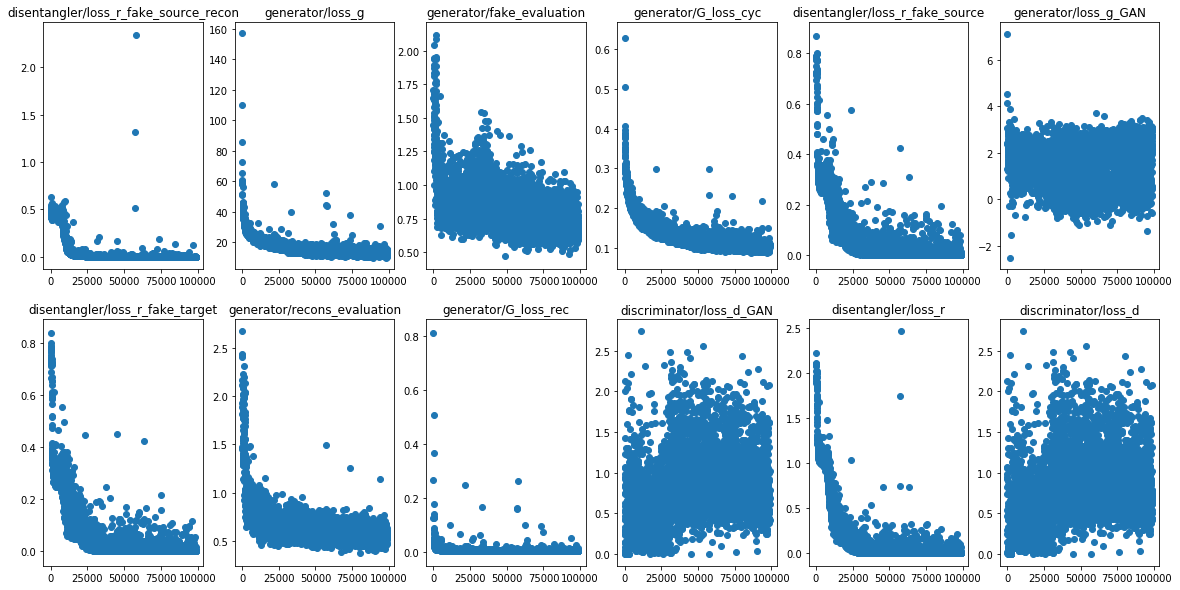

In [13]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(log_file_name,size_guidance={ 
    event_accumulator.COMPRESSED_HISTOGRAMS: 1,
    event_accumulator.IMAGES: 1,
    event_accumulator.AUDIO: 1,
    event_accumulator.SCALARS: 5000,
    event_accumulator.HISTOGRAMS: 1,
    })
ea.Reload()
scalars = ea.Tags()['scalars']
def plot(scalars):
    plt.figure(figsize=(20,10))
    n = int(len(scalars)/2)
    if len(scalars)%2 != 0:
        n += 1
    counter = 1
    for s in scalars:
        plt.subplot(2,n,counter)
        df = pd.DataFrame(ea.Scalars(s))
        plt.scatter(x=df['step'], y=df['value'])
        plt.title(s)
        counter += 1
    plt.show()    
plot(scalars)

# Run an Experiment

In [14]:
ckpt_dir_cls

'../output/classifier/CelebA-Smile'

In [15]:
try:
    categories, file_names_dict = read_data_file('.'+ config['image_label_dict'])
except:
    print("Problem in reading input data file : ", config['image_label_dict'])
    sys.exit()
data = np.asarray(list(file_names_dict.keys()))
print("The classification categories are: ")
print(categories)
print('The size of the training set: ', data.shape[0])
data[0:10]

The classification categories are: 
['0-0.09', '0.1-0.19', '0.2-0.29', '0.3-0.39', '0.4-0.49', '0.5-0.59', '0.6-0.69', '0.7-0.79', '0.8-0.89', '0.9-0.99']
The size of the training set:  48332


array(['084077.jpg', '182601.jpg', '172439.jpg', '158347.jpg',
       '064753.jpg', '068468.jpg', '111647.jpg', '034984.jpg',
       '090846.jpg', '084153.jpg'], dtype='<U10')

In [16]:
k_dim

2

In [17]:
fake_img = np.empty([])
real_prediction = np.empty([])
fake_prediction = np.empty([])
real_img = np.empty([])

np.random.shuffle(data)
image_paths = data

num_seed_imgs = 8
img, labels = load_images_and_labels(image_paths[0:num_seed_imgs], os.path.join('..', config['image_dir']), 1,
                                     file_names_dict, input_size, channels, do_center_crop=True)

print("Size of source images: ", img.shape)

labels = np.repeat(labels, NUMS_CLASS * k_dim, 0)
labels = labels.ravel()
labels = convert_ordinal_to_binary(labels, NUMS_CLASS)
img_repeat = np.repeat(img, NUMS_CLASS * k_dim, 0)

target_labels = np.asarray([np.asarray(range(NUMS_CLASS)) for j in range(num_seed_imgs * k_dim)])
target_labels = target_labels.ravel()
print("Size of target labels: ", target_labels.shape)

identity_ind = labels == target_labels
target_labels = convert_ordinal_to_binary(target_labels, NUMS_CLASS)

if disentangle:
    target_disentangle_ind = np.asarray(
        [np.repeat(np.asarray(range(k_dim)), NUMS_CLASS) for j in range(num_seed_imgs)])
    target_disentangle_ind = target_disentangle_ind.ravel()
    target_disentangle_ind_one_hot = np.eye(k_dim)[target_disentangle_ind]
    target_disentangle_ind_one_hot[identity_ind, :] = 0
    my_feed_dict = {y_t: target_labels, x_source: img_repeat, train_phase: False,
                    y_s: labels,
                    y_regularizer: target_disentangle_ind, y_r: target_disentangle_ind_one_hot}
else:
    my_feed_dict = {y_t: target_labels, x_source: img_repeat, train_phase: False,
                    y_s: labels}



FAKE_IMG, real_pred, fake_pred = sess.run([ fake_target_img,\
                              real_img_cls_prediction, fake_img_cls_prediction], \
                              feed_dict=my_feed_dict)

real_img = img
fake_img = FAKE_IMG
real_prediction = real_pred
fake_prediction = fake_pred

print(real_img.shape)
print(fake_img.shape)
print(real_prediction.shape)
print(fake_prediction.shape)

8it [00:00, 121.95it/s]

Size of source images:  (8, 128, 128, 3)
Size of target labels:  (160,)


(8, 128, 128, 3)
(160, 128, 128, 3)
(160, 2)
(160, 2)


# View

In [18]:
def save_target_images(img, num_class, image_size=128,num_channel=3):
    img = make3d(img, num_channel=num_channel, image_size=image_size, row=1, col=num_class)                      
    img = inverse_image(img)
    return img

In [19]:
def view(img, num_samples, NUMS_CLASS, k_dim, real_pred, FAKE_IMG, fake_pred):
    img = inverse_image(img)
    start = 0
    fake_pred = np.round(fake_pred, decimals=2)
    for i in range(num_samples):
        plt.figure(figsize = (3,3))
        plt.imshow(img[i])
        plt.title(str(" Output of pre. cls: ") + str(real_pred[start][1]))
        plt.show()
        for j in range(k_dim):
            plt.figure(figsize = (20,20))
            temp = save_target_images(FAKE_IMG[start+j*NUMS_CLASS:start+(j+1)*NUMS_CLASS], NUMS_CLASS)
            plt.title("Knob {} - ".format(j)+"Generated image cls output: " + str(
                fake_pred[start+j*NUMS_CLASS:start+(j+1)*NUMS_CLASS][:, 1]))
            plt.imshow(temp)
            plt.show()

        start = start + NUMS_CLASS * k_dim

# Save Results

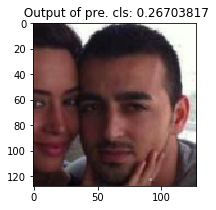

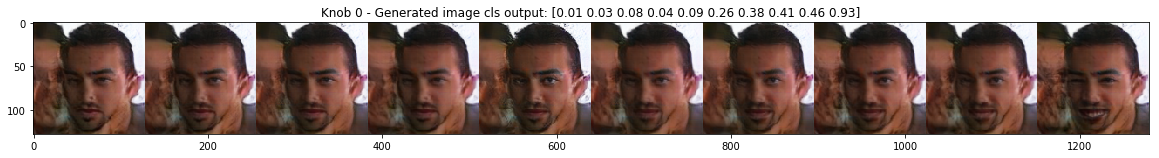

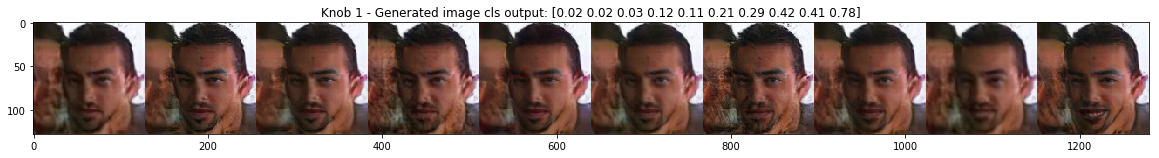

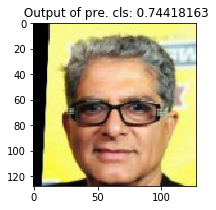

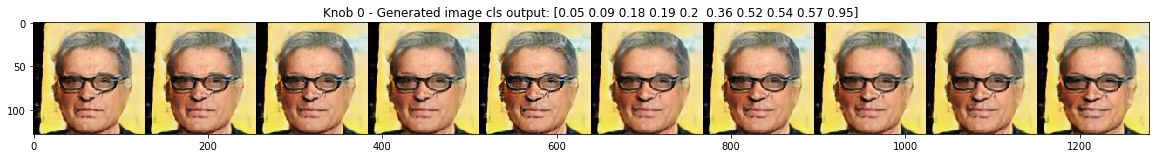

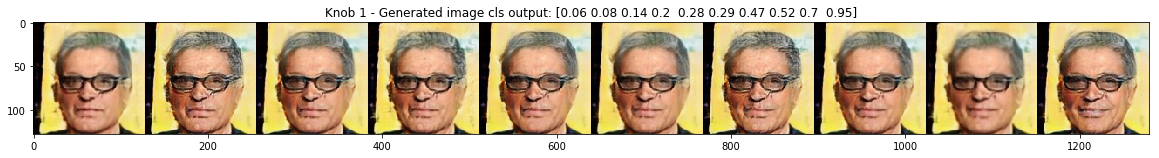

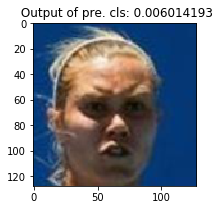

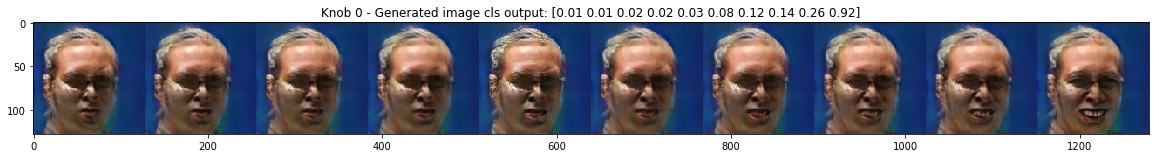

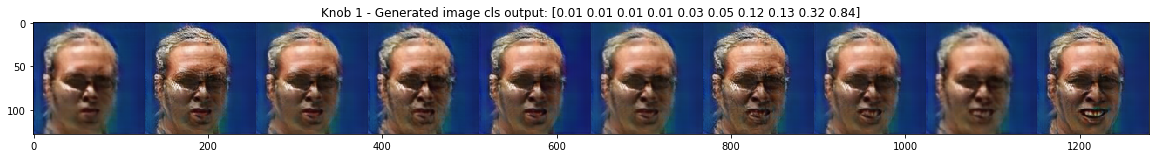

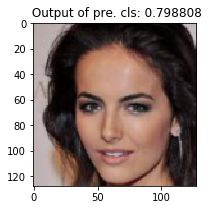

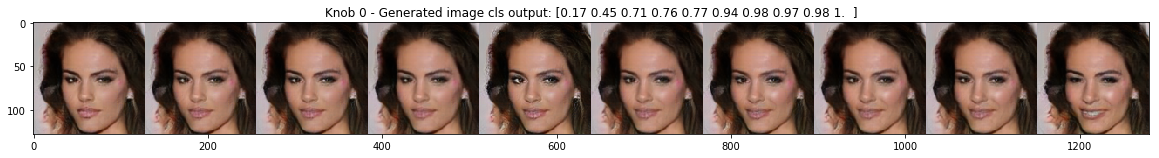

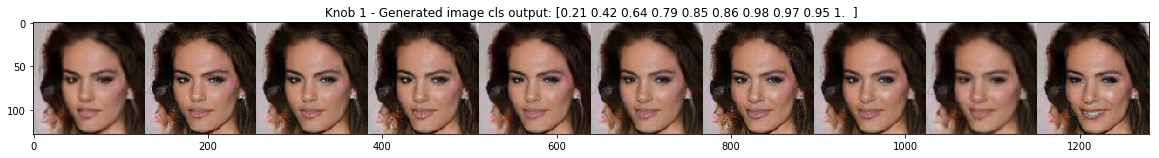

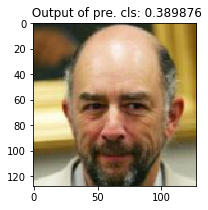

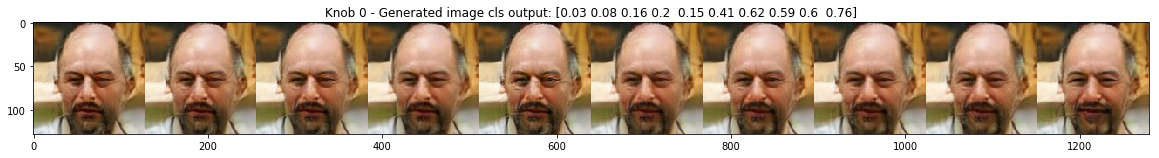

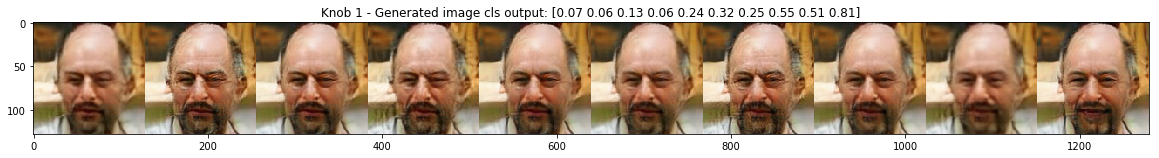

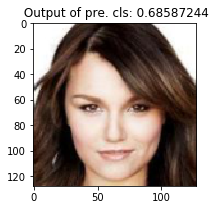

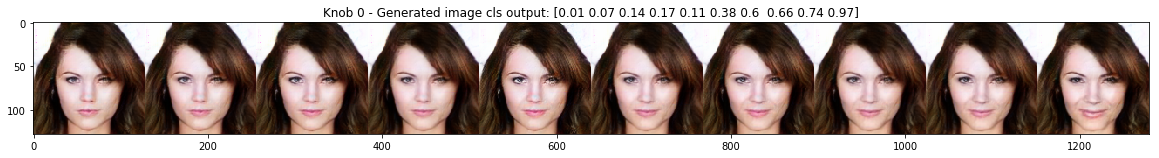

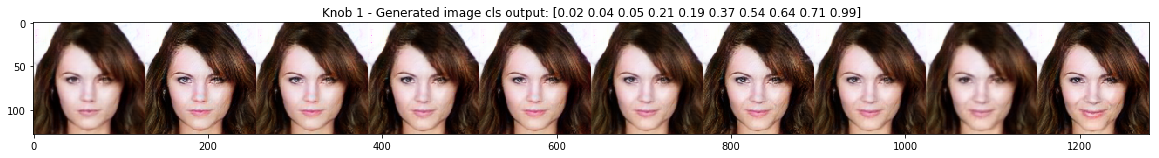

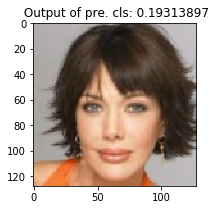

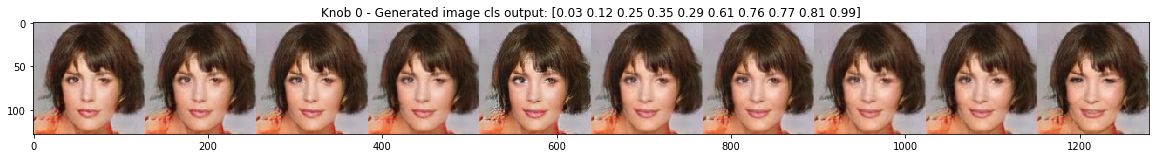

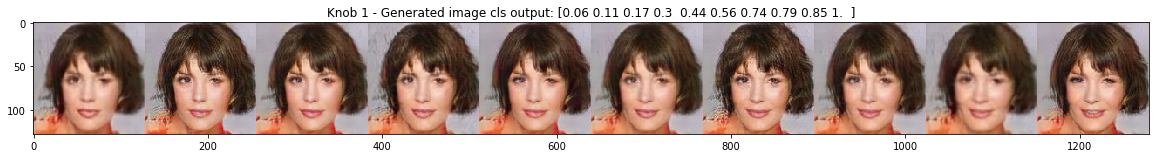

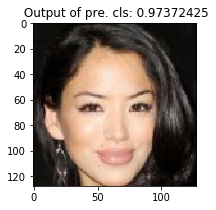

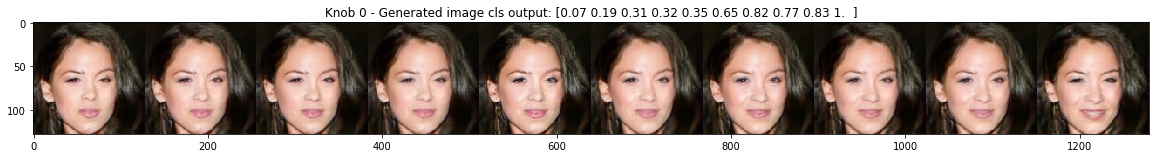

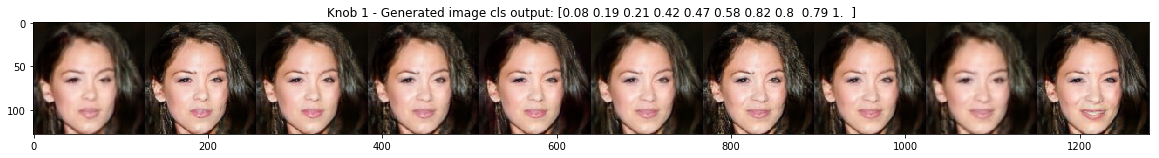

In [20]:
num_samples = 8
NUM_CLASS = 10
view(real_img[0:num_samples], num_samples, NUM_CLASS, k_dim, real_prediction[0:num_samples*NUM_CLASS*k_dim], 
     fake_img[0:num_samples*NUM_CLASS*k_dim], fake_prediction[0:num_samples*NUM_CLASS*k_dim])
